# Project: **Finding Lane Lines on the Road** 
***
Develop a pipeline to identify lane lines on the road. You must apply it on a series of individual images, provided in the *test_images* folder. 

Once you have a result that looks roughly like the image *line-segments-example* in the examples folder (also shown below), you'll need to try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [111]:
#importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


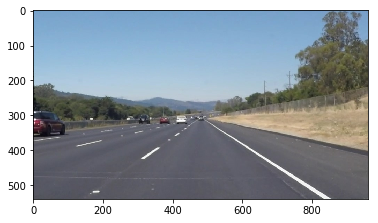

In [112]:
#reading in an image
image = cv2.imread('test_images/solidWhiteRight.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

Below are some helper functions to help get you started.

In [113]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, k1=9, k2=9):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (k1,k2), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an np.array with the lines
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

## Test Images

Build your pipeline to work on the images in the directory "test_images"

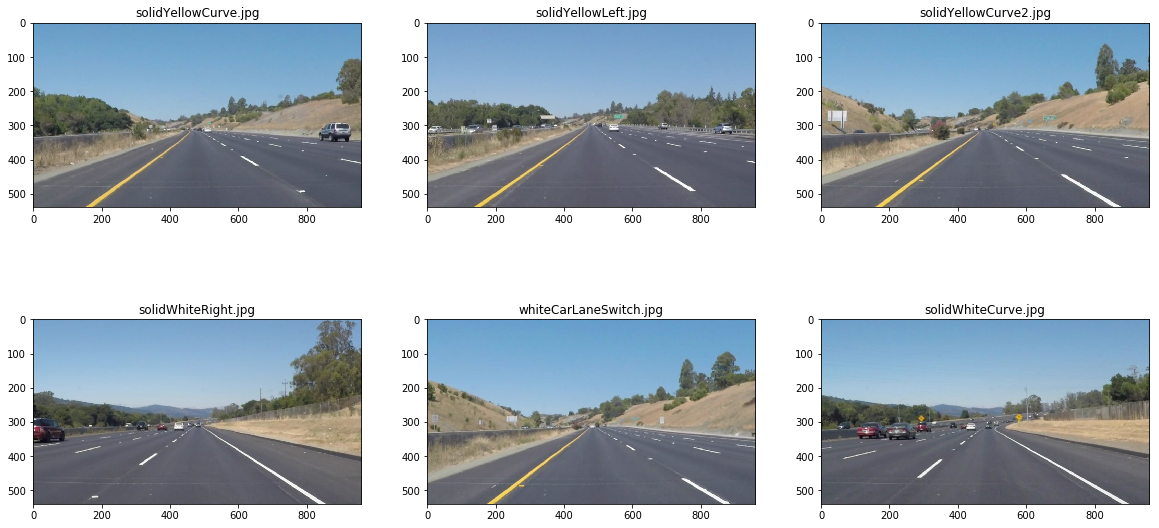

In [114]:
import os

path  = "test_images/"
files = os.listdir(path)

images, edges = [], [] 

f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots    = [plot for sublist in plots for plot in sublist]

for file, plot in zip(files, plots):
    image = cv2.cvtColor(
        cv2.imread(os.path.join(path, file)), 
        cv2.COLOR_BGR2RGB
    )
    plot.set_title(file)
    plot.imshow(image)
    images.append((image, file))

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

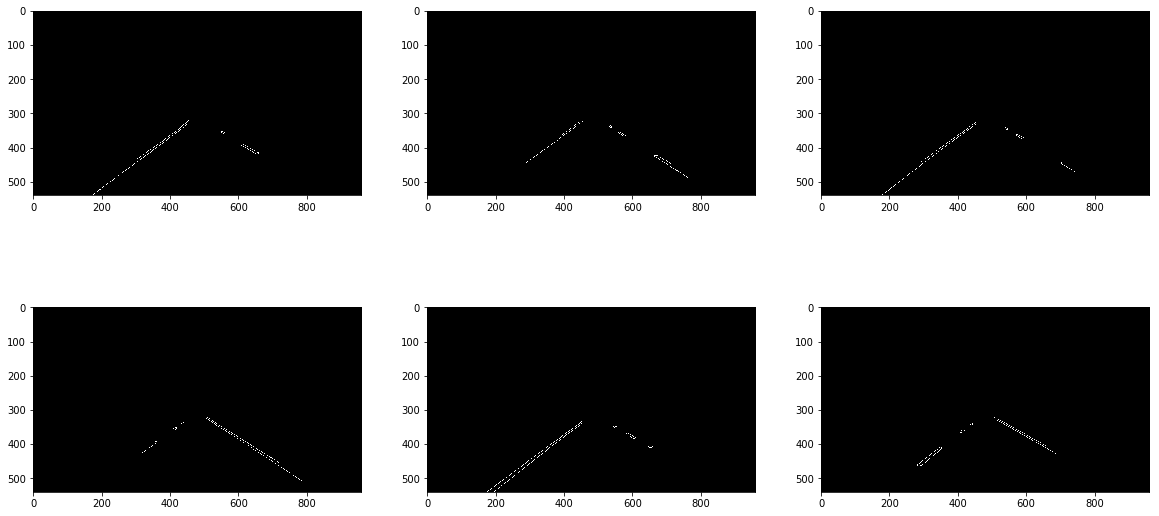

In [115]:
# TODO: Build your pipeline that will draw lane lines segments on the test_images
# Eliminate the sky in all images with a mask  
lane_dim = np.array(
            [[ 90, 600],
            [ 450, 320],
            [ 550, 320],
            [ 900, 600]])

f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots    = [plot for sublist in plots for plot in sublist]

for img, plot in zip(images, plots):
    gray_lane = grayscale(img[0])
    gauss = gaussian_blur(gray_lane, 9,9)
    edge = canny(gauss, 100, 200)
    lane_img = region_of_interest(edge, lane_dim)
    edges.append(lane_img)
    plot.imshow(lane_img, cmap="gray")

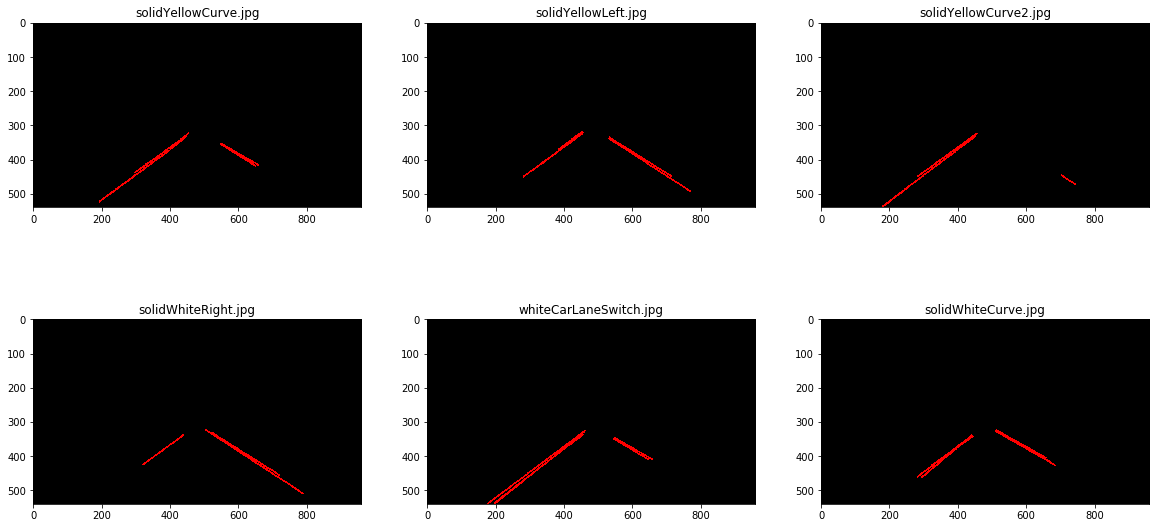

In [116]:
# Detect lines
f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots    = [plot for sublist in plots for plot in sublist]

# HoughLine parameter (constants)
rho          = 2
theta        = np.pi/180
threshold    = 50
min_line_len = 20
max_line_gap = 100

line_images = []

for img, original_image, plot in zip(edges, images, plots):
    # Find lines given Canny img
    lane_img, lines = hough_lines(
                img, 
                rho, 
                theta, 
                threshold, 
                min_line_len, 
                max_line_gap)
    line_images.append(lane_img)
    plot.set_title(original_image[1])
    plot.imshow(lane_img)

## Improve the draw_lines() function

**At this point, you should have the Hough line segments drawn onto the road. Extend your code to define a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. Try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. The output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

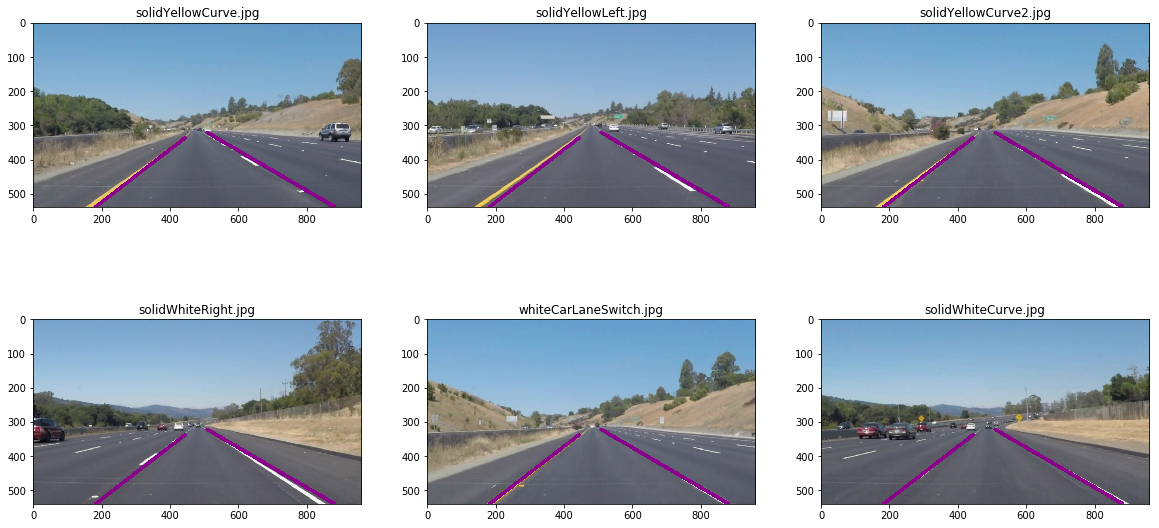

In [118]:
# Group in Right & Left sides, then draw one line per group
f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots    = [plot for sublist in plots for plot in sublist]

for img, original_image, plot in zip(line_images, images, plots):
    # Group the lines by their slope (m)
    # - Left group: + slope
    # - Right group: - slope
    m      = 0
    rX, rY = [], []
    lX, lY = [], []

    for l in lines:
        for x1, y1, x2, y2 in l:
            m = math.degrees(math.atan2(x1 - y1, x2 - x2))
            if m > 0:
                lX += [x1,x2]
                lY += [y1,y2]
            else:
                rX += [x1,x2]
                rY += [y1,y2]
    
    # Drawing parameters for the final image
    final_image    = np.copy(original_image[0])
    line_color     = (139,0,139)
    line_thickness = 10
    
    # Now that we have the line in their groups, polyfit the values
    # then do math stuff to calc the resulting line
    z = np.polyfit(rX,rY,1)
    m, b  = z[0], z[1]
    
    # y = mx+b
    x1 = int((final_image.shape[0] - b) / m)
    x2 = max(rX)
    y1 = int(m * x1 + b)
    y2 = int(m * x2 + b)
    
    cv2.line(final_image,(x1,y1),(x2,y2), line_color, line_thickness)
    
    z = np.polyfit(lX,lY,1)
    m, b = z[0], z[1]
    
    x1 = min(lX)
    x2 = int((final_image.shape[0] - b) / m)
    y1 = int(m * x1 + b)
    y2 = int(m * x2 + b)
    
    cv2.line(final_image,(x1,y1),(x2,y2), line_color, line_thickness)
    
    # At this point, we have finished all the pipeline, now we'll graph the
    # final result
    plot.set_title(original_image[1])
    plot.imshow(final_image)